In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import itertools
import warnings
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
df = pd.read_csv('Fraud.csv')

In [3]:
# Filter rows that nameDest starts with 'M' (Merchant)
merchant_rows = df[df['nameDest'].str.startswith('M')]

In [4]:
df = df[~df['nameDest'].str.startswith('M')]

In [5]:
df = df.sort_values(by='step')

train_split = 575

train = df[df['step'] <= train_split]
test = df[df['step'] > train_split]

In [6]:
train['train_test'] = 1
test['train_test'] = 0

C:\Users\Lucas\AppData\Local\Temp\ipykernel_2924\1489182613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train_test'] = 1
C:\Users\Lucas\AppData\Local\Temp\ipykernel_2924\1489182613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['train_test'] = 0


In [7]:
true_count = df['isFraud'].sum()
false_count = len(df) - true_count

print(f'True values (1): {true_count}')
print(f'False values (0): {false_count}')

True values (1): 8213
False values (0): 4202912


In [8]:
def apply_transformations(df):
    categories = ['CASH_IN', 'CASH_OUT', 'TRANSFER', 'DEBIT'] 
    
    
    df['type'] = df['type'].apply(lambda x: x if x in categories else 'PAYMENT')
    
    category_mapping = {'CASH_IN': 1, 'CASH_OUT': 2, 'TRANSFER': 3, 'DEBIT': 4}
    
    df['type_encoded'] = df['type'].map(category_mapping)
    
    numeric_columns = ['step', 'amount', 
                       'oldbalanceOrg', 'newbalanceOrig', 
                       'oldbalanceDest', 'newbalanceDest']
    
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    
    df_encoded = df.drop(['type'], axis=1)
    
    return df_encoded


training_final = apply_transformations(train.copy())
test_final = apply_transformations(test.copy())
numeric_columns = ['step', 'amount',
                   'oldbalanceOrg', 'newbalanceOrig',
                   'oldbalanceDest', 'newbalanceDest']

scaler = StandardScaler()
X_train_scaled = training_final.drop(['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
X_train_scaled[numeric_columns] = scaler.fit_transform(X_train_scaled[numeric_columns])
y_train = training_final['isFraud']
X_train_scaled.columns = X_train_scaled.columns.astype(str)

In [9]:

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

X_train_scaled_imputed = preprocessor.fit_transform(X_train_scaled)


smote = SMOTE(sampling_strategy=0.0075, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled_imputed, y_train)


X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train_scaled.columns)
y_train_resampled_df = pd.Series(y_train_resampled, name='isFraud')


X_test_scaled = test_final.drop(['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
X_test_scaled.columns = X_test_scaled.columns.astype(str)
y_test = test_final['isFraud']


print("Train set transactions:", X_train_resampled_df.shape[0])
print("Test set transactions:", X_test_scaled.shape[0])


batch_size = 10000
num_batches = len(X_train_resampled_df) // batch_size

X_train_batches = []
y_train_batches = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    X_batch = X_train_resampled_df.iloc[start_idx:end_idx, :]
    y_batch = y_train_resampled_df.iloc[start_idx:end_idx]
    X_train_batches.append(X_batch)
    y_train_batches.append(y_batch)


if len(X_train_resampled_df) % batch_size != 0:
    X_batch = X_train_resampled_df.iloc[num_batches * batch_size:, :]
    y_batch = y_train_resampled_df.iloc[num_batches * batch_size:]
    X_train_batches.append(X_batch)
    y_train_batches.append(y_batch)


X_train_final = pd.concat(X_train_batches)
y_train_final = pd.concat(y_train_batches)

Train set transactions: 4128735
Test set transactions: 106766


In [10]:
print("Forma de X_train:", X_train_final.shape)
print("Forma de y_train:", y_train_final.shape)

Forma de X_train: (4128735, 8)
Forma de y_train: (4128735,)


In [11]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# AUC-ROC and AUC-PR are not readily available in Keras, so we use sklearn metrics
from sklearn.metrics import auc, roc_curve, precision_recall_curve
# Compile the model
from keras import backend as K
from tensorflow.keras.metrics import AUC
# Assuming you have already preprocessed your data and have X_train_final and y_train_final

# Reshape the input data to be 3-dimensional (samples, timesteps, features)
X_train_reshaped = np.reshape(X_train_final.values, (X_train_final.shape[0], 1, X_train_final.shape[1]))

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(1, X_train_final.shape[1])))
lstm_model.add(Dense(units=1, activation='sigmoid'))


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    f1_score = 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))
    return f1_score





# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(1, X_train_final.shape[1])))
lstm_model.add(Dense(units=1, activation='sigmoid'))

# Define AUC metrics
auc_roc = AUC(curve='ROC', name='auc_roc')
auc_pr = AUC(curve='PR', name='auc_pr')

# Compile the model with the additional metrics
lstm_model.compile(optimizer='adam', 
                   loss='binary_crossentropy', 
                   metrics=['accuracy', precision, recall, f1_score, auc_roc, auc_pr])

# Train the model
lstm_model.fit(X_train_reshaped, y_train_final, epochs=10, batch_size=10000)


# Now you can use this trained model to make predictions on new data


Epoch 1/10
413/413 [==============================] - 43s 92ms/step - loss: 0.1996 - accuracy: 0.9868 - precision: 0.8672 - recall: 0.1534 - f1_score: 0.2123 - auc_roc: 0.6204 - auc_pr: 0.1311
Epoch 2/10
413/413 [==============================] - 38s 91ms/step - loss: 0.0317 - accuracy: 0.9941 - precision: 0.9911 - recall: 0.2034 - f1_score: 0.3346 - auc_roc: 0.8551 - auc_pr: 0.4435
Epoch 3/10
413/413 [==============================] - 37s 91ms/step - loss: 0.0252 - accuracy: 0.9946 - precision: 0.9883 - recall: 0.2715 - f1_score: 0.4231 - auc_roc: 0.9000 - auc_pr: 0.5458
Epoch 4/10
413/413 [==============================] - 37s 90ms/step - loss: 0.0224 - accuracy: 0.9949 - precision: 0.9830 - recall: 0.3213 - f1_score: 0.4815 - auc_roc: 0.9068 - auc_pr: 0.5967
Epoch 5/10
413/413 [==============================] - 37s 91ms/step - loss: 0.0208 - accuracy: 0.9952 - precision: 0.9772 - recall: 0.3579 - f1_score: 0.5212 - auc_roc: 0.9112 - auc_pr: 0.6321
Epoch 6/10
413/413 [===============

In [12]:
# 5. Guardar el modelo entrenado
def save_model(model, filename):
    model.save(filename)

save_model(lstm_model, 'modelo_entrenadolstm.h5')

c:\Users\Lucas\tenflow\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), input_shape=(1, X_train_final.shape[1])))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', precision, recall, f1_score, auc_roc, auc_pr]
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hypparam')

tuner.search_space_summary()

tuner.search(X_train_reshaped, y_train_final, epochs=5, batch_size=2000)

tuner.results_summary()

Reloading Tuner from my_dir\hypparam\tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}
Results summary
Results in my_dir\hypparam
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 2 summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.9978090226650238

Trial 0 summary
Hyperparameters:
units: 128
learning_rate: 0.0001
Score: 0.9951205253601074

Trial 1 summary
Hyperparameters:
units: 32
learning_rate: 0.0001
Score: 0.9945291876792908


C:\Users\Lucas\AppData\Local\Temp\ipykernel_2924\3047316967.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [14]:
# 5. Guardar el modelo entrenado
def save_model(model, filename):
    model.save(filename)

save_model(lstm_model, 'modelo_entrenadolstmhp.keras')

3337/3337 [==============================] - 7s 2ms/step


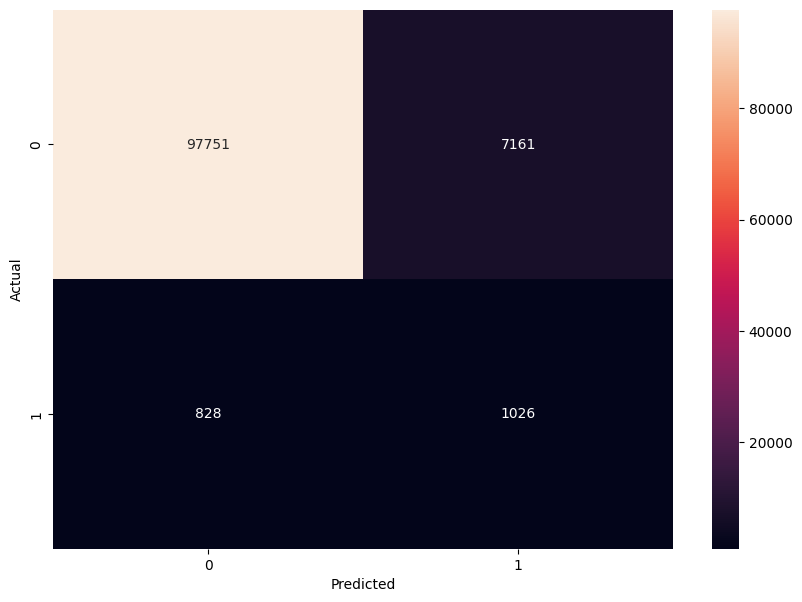

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Add a time dimension to the input data
X_test_reshaped = np.reshape(X_test_scaled.values, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
# Make predictions
y_pred = (best_model.predict(X_test_reshaped) > 0.0001)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()